## Graph Analysis Codes for Concept Maps
*ver-1.0.0*

**This program is designed to run in `Windows` env.**

(Still working on adding other domains.)

Requirements:
- Pandas
- Matplotlib
- NetworkX

#### Load packages

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

#### Methods for individual metrics
1. `num_of_concepts`: 노드 개수와 동일
2. `num_of_relationships`: 엣지 개수와 동일
3. `num_of_hierarchies`
4. `num_of_crosslinks`
5. `cal_aspl`: Average shortest path length
6. `cal_cc`: Clustering coefficient
7. `cal_network_density`
8. `cal_complexity`
9. `get_level_deepest_hierarchy`

In [2]:
def num_of_concepts(G):
    return G.number_of_nodes()

def num_of_relationships(G):
    return G.number_of_edges()

def num_of_hierarchies(G):
    return nx.number_of_strongly_connected_components(G)

def num_of_crosslinks(G):
    return num_of_relationships(G) - num_of_concepts(G) + num_of_hierarchies(G)

def cal_aspl(G):
    try :
        return nx.average_shortest_path_length(G)
    except nx.exception.NetworkXError:
        print("Error: Graph is not connected")
        return 0

def cal_cc(G):
    return nx.average_clustering(G)

def cal_network_density(G):
    return nx.density(G)

def cal_complexity(G):
    E = G.number_of_edges()
    N = G.number_of_nodes()
    return (E / N) if (N > 0) else 0

def get_level_deepest_hierarchy(G):
    return max([len(nx.shortest_path(G, source, target)) for source in G for target in G])

#### Load data

In [3]:
# This is a sampling for entire analysis
data_astronomy1 = pd.read_excel('data/Astronomy.xlsx', sheet_name='강민철')
data_astronomy2 = pd.read_excel('data/Astronomy.xlsx', sheet_name='강지헌')

# Drop an useless column
data_astronomy1.drop('Name', axis=1, inplace=True)
data_astronomy2.drop('Name', axis=1, inplace=True)

# Merge all dataframes into one dataframe:
data_astronomy = pd.concat([data_astronomy1, data_astronomy2], axis=0)
# data_astronomy

In [4]:
data_sampling1 = pd.read_excel('data/Sampling.xlsx', sheet_name='강지헌')
data_sampling2 = pd.read_excel('data/Sampling.xlsx', sheet_name='신아현')
data_sampling3 = pd.read_excel('data/Sampling.xlsx', sheet_name='신수연')

data_sampling1.drop('Name', axis=1, inplace=True)
data_sampling2.drop('Name', axis=1, inplace=True)
data_sampling3.drop('Name', axis=1, inplace=True)

data_sampling = pd.concat([data_sampling1, data_sampling2, data_sampling3], axis=0)
# data_sampling

In [5]:
data_database1 = pd.read_excel('data/Database.xlsx', sheet_name='신수연')
data_database2 = pd.read_excel('data/Database.xlsx', sheet_name='양연선')
data_database3 = pd.read_excel('data/Database.xlsx', sheet_name='김나영')

data_database1.drop('Name', axis=1, inplace=True)
data_database2.drop('Name', axis=1, inplace=True)
data_database3.drop('Name', axis=1, inplace=True)

data_database = pd.concat([data_database1, data_database2, data_database3], axis=0)
# data_database

#### Process graphs
- 이름 형식: `<Domain>_<Modality>_<ID>`
- Domain: `ASTRONOMY`, `SAMPLING`, `DATABASE`

***참고사항**:
    혹시 몰라 노드에 P.Knowledge를 추가로 라벨링해두었지만, 분석할 때는 그냥 df상에서도 충분히 가능해보임*

In [6]:
graphs_astronomy = {}

for id, sub_df in data_astronomy.groupby('ID'):
    # New graph object
    graph_name = f"Astronomy_{sub_df['Mod.'].iloc[0]}_{sub_df['ID'].iloc[0]}"
    G = nx.DiGraph()
    
    # Add nodes and edges
    for _, row in sub_df.iterrows():
        start_node = row['Start']
        if pd.notna(row['End']):
            end_nodes = [end_node.rstrip() for end_node in row['End'].split(',')]
            for end_node in end_nodes:
                G.add_edge(start_node, end_node)
        # Add p.knowledge labels:  O -> 1(true)  |  X -> 0(false)
        try:
            G.nodes[start_node]['P.Knowledge'] = 1 if row['P.Knowledge'] == 'O' else 0
        except KeyError:
            G.add_node(start_node)
            G.nodes[start_node]['P.Knowledge'] = 0
    
    # Save the graph
    graphs_astronomy[graph_name] = G

In [7]:
graphs_sampling = {}

for id, sub_df in data_sampling.groupby('ID'):
    # New graph object
    graph_name = f"Sampling_{sub_df['Mod.'].iloc[0]}_{sub_df['ID'].iloc[0]}"
    G = nx.DiGraph()
    
    # Add nodes and edges
    for _, row in sub_df.iterrows():
        start_node = row['Start']
        if pd.notna(row['End']):
            end_nodes = [end_node.rstrip() for end_node in row['End'].split(',')]
            for end_node in end_nodes:
                G.add_edge(start_node, end_node)
        # Add p.knowledge labels:  O -> 1(true)  |  X -> 0(false)
        try:
            G.nodes[start_node]['P.Knowledge'] = 1 if row['P.Knowledge'] == 'O' else 0
        except KeyError:
            G.add_node(start_node)
            G.nodes[start_node]['P.Knowledge'] = 0
    
    # Save the graph
    graphs_sampling[graph_name] = G

In [8]:
graphs_database = {}

for id, sub_df in data_database.groupby('ID'):
    # New graph object
    graph_name = f"Database_{sub_df['Mod.'].iloc[0]}_{sub_df['ID'].iloc[0]}"
    G = nx.DiGraph()
    
    # Add nodes and edges
    for _, row in sub_df.iterrows():
        start_node = row['Start']
        if pd.notna(row['End']):
            end_nodes = [end_node.rstrip() for end_node in row['End'].split(',')]
            for end_node in end_nodes:
                G.add_edge(start_node, end_node)
        # Add p.knowledge labels:  O -> 1(true)  |  X -> 0(false)
        try:
            G.nodes[start_node]['P.Knowledge'] = 1 if row['P.Knowledge'] == 'O' else 0
        except KeyError:
            G.add_node(start_node)
            G.nodes[start_node]['P.Knowledge'] = 0
    
    # Save the graph
    graphs_database[graph_name] = G

#### Draw graphs

In [9]:
# Set Korean font
import matplotlib.font_manager as fm 
from matplotlib import rc
font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

In [10]:
def draw_graph(graph_dict, end_point = None):
    """This function is used to draw the graph from the `graph_dict`

    Args:
        graph_dict (`dict`): A processed graph dictionary
        end_point (`str`, optional): A break point for the loop. Defaults to None. It will ends after the graph with the same name as `end_point`. The format is `Domain_Mod_ID`.
    """
    for graph_name, G in graph_dict.items():
        pos = nx.spring_layout(G)
        labels = {node: f"{node} ({G.nodes[node].get('P.Knowledge', 'N/A')})" for node in G.nodes()}
        plt.figure(figsize=(10, 7))
        nx.draw(G, pos, with_labels=True, labels=labels, node_size=700, node_color='lightblue', font_family=font_name)
        plt.title(f"{graph_name}")
        plt.show()
        
        # For test you can stop with this:
        if graph_name == end_point:
            break
    plt.close()

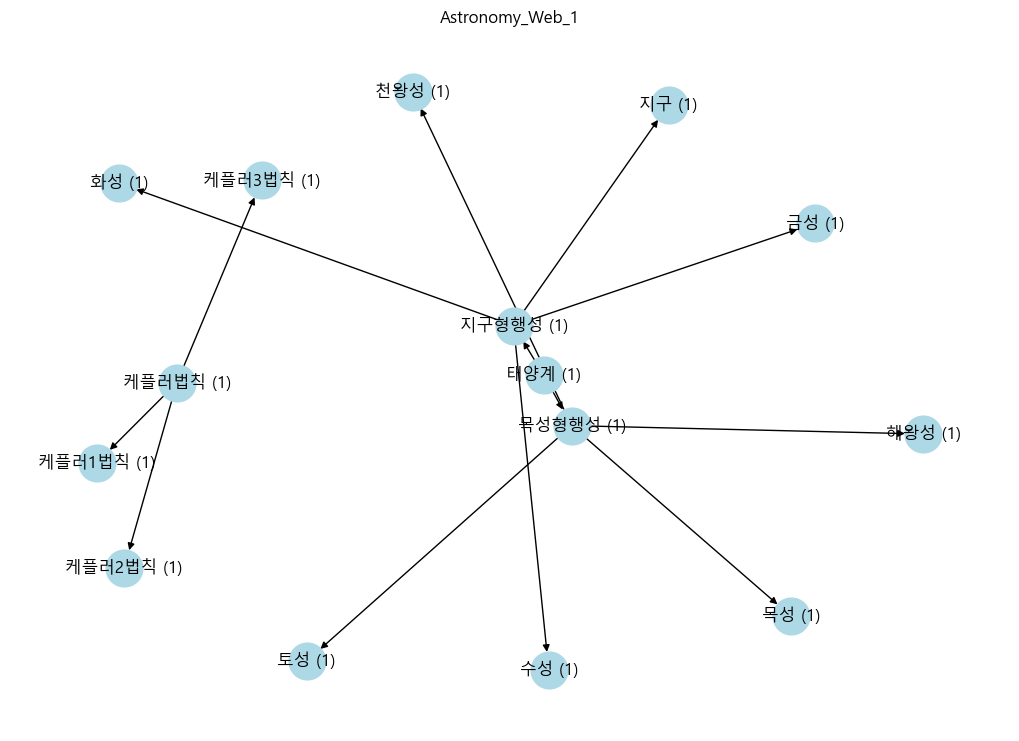

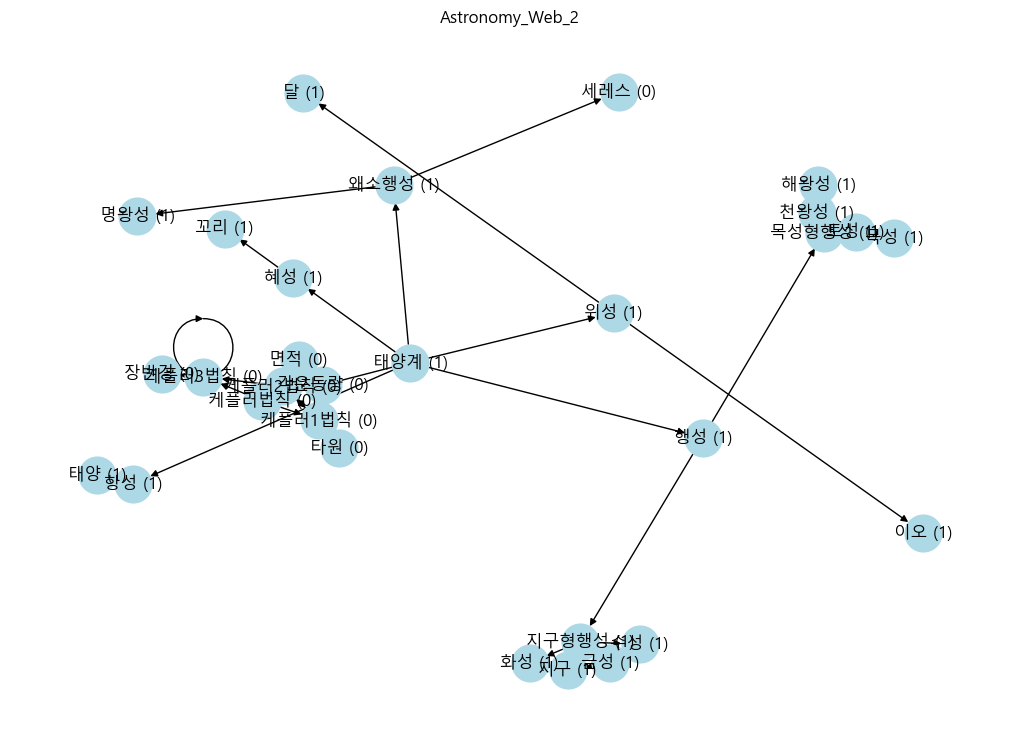

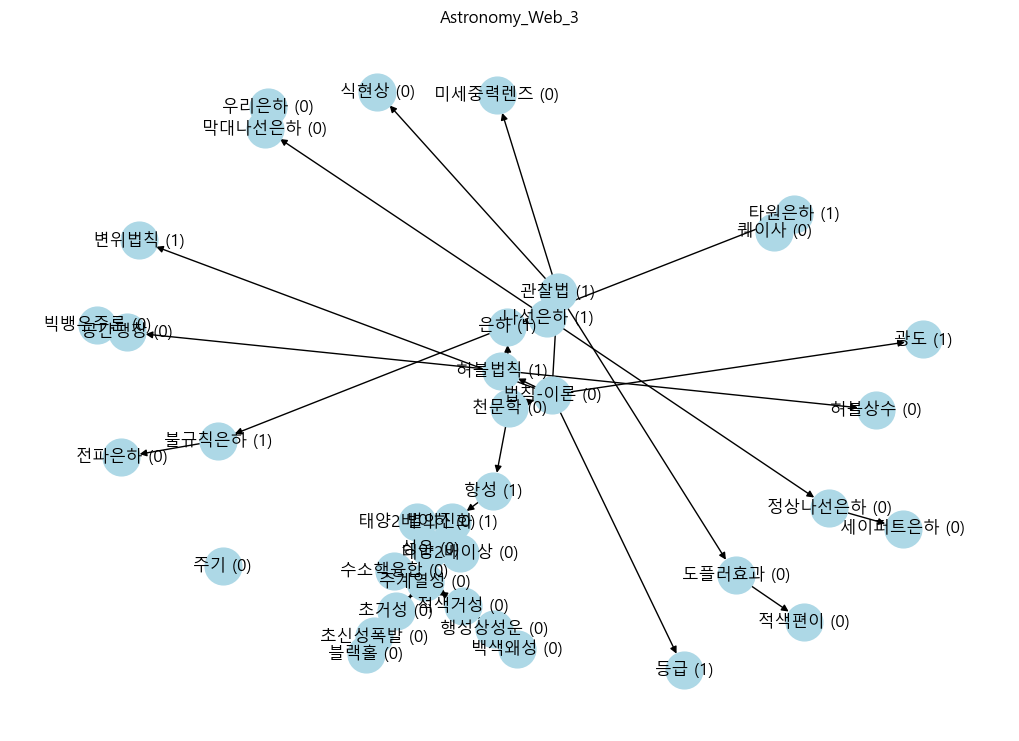

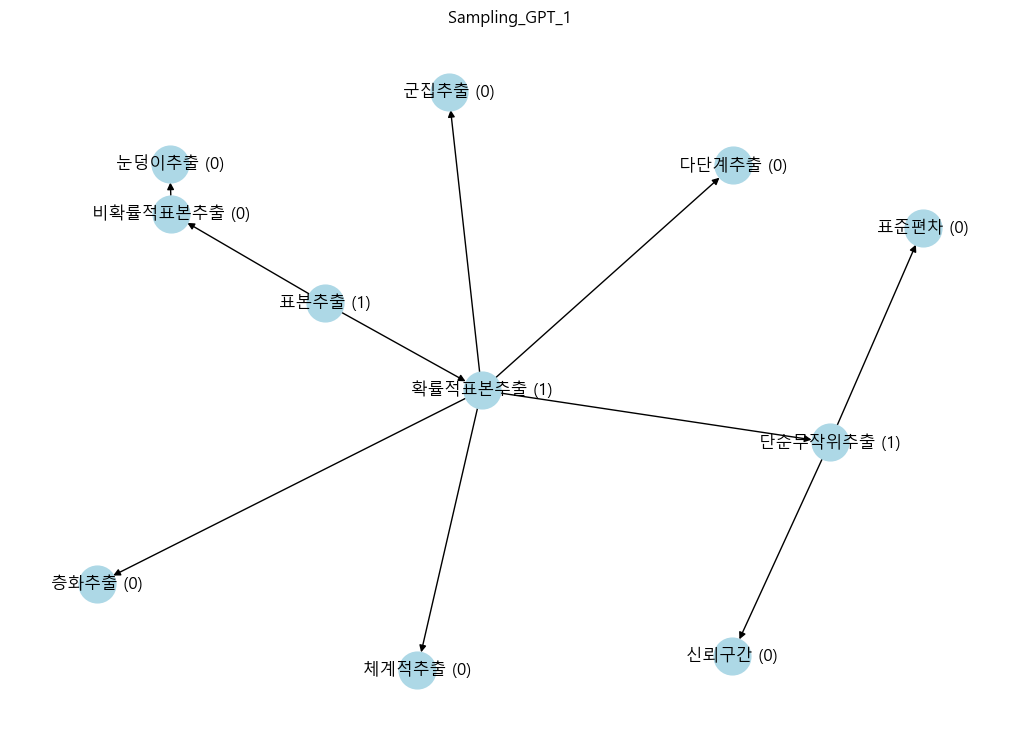

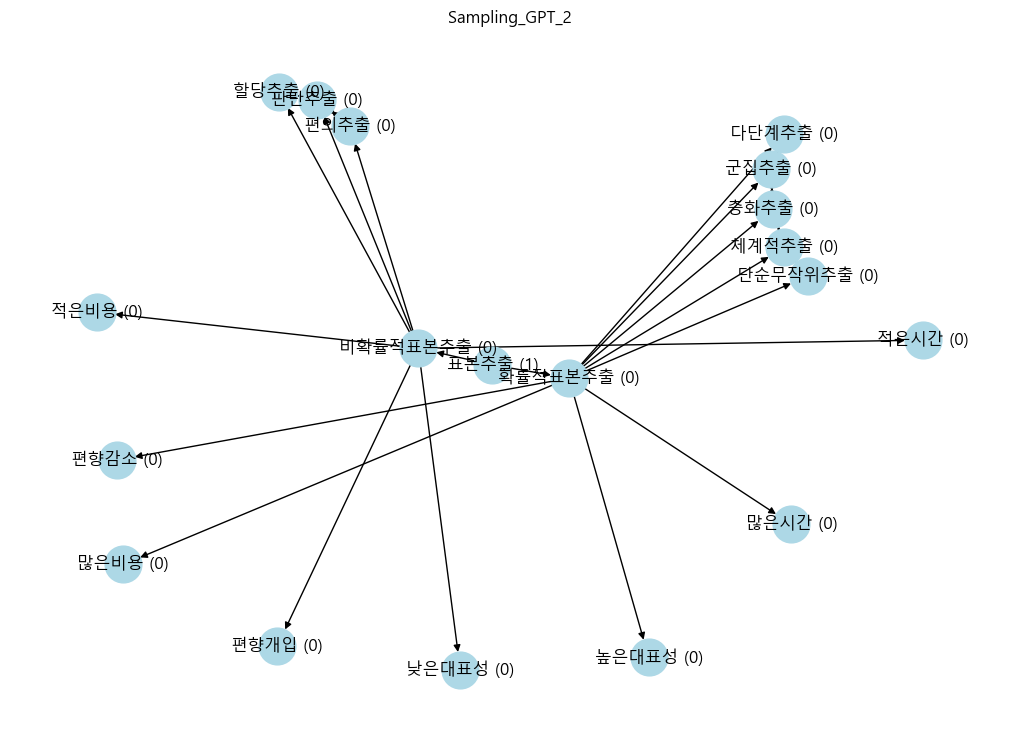

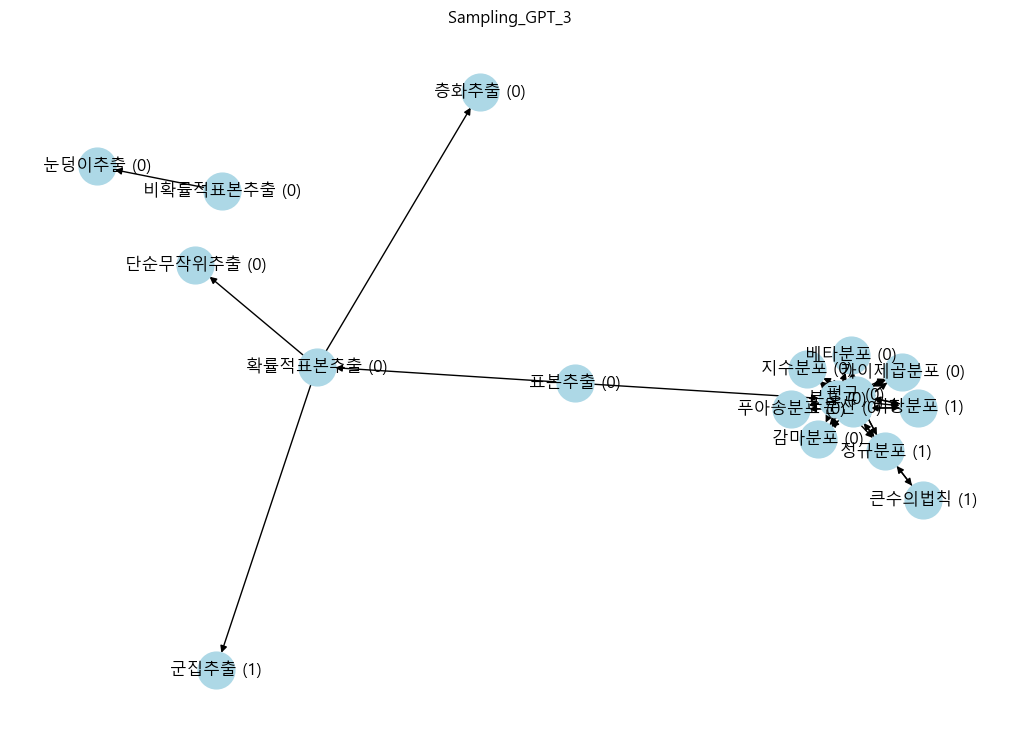

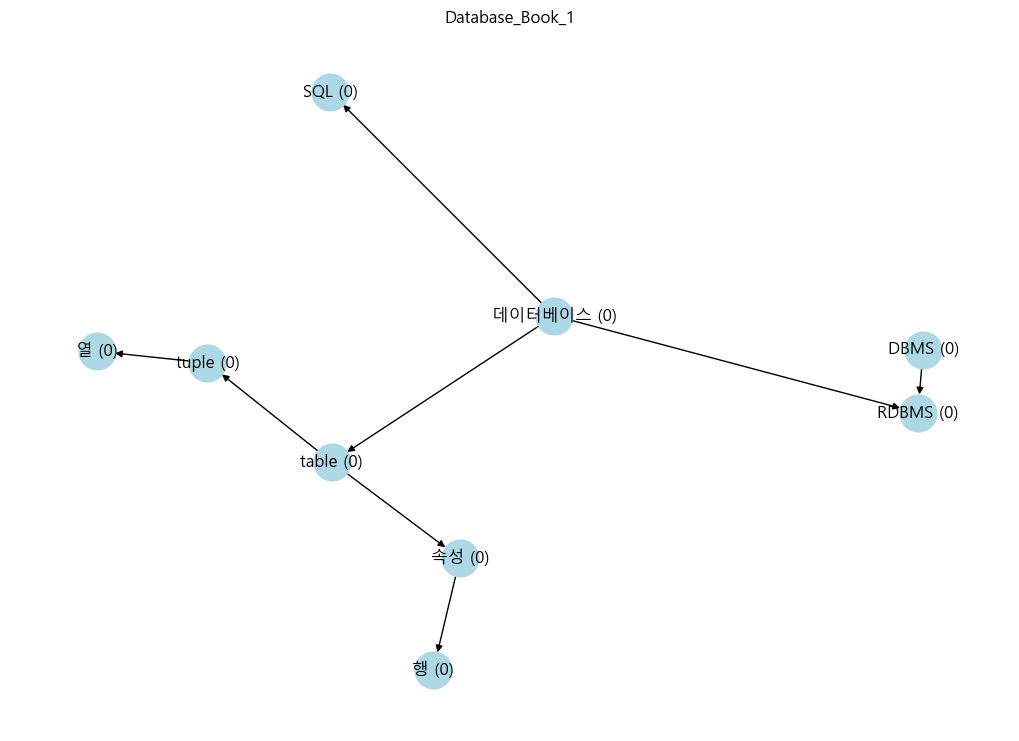

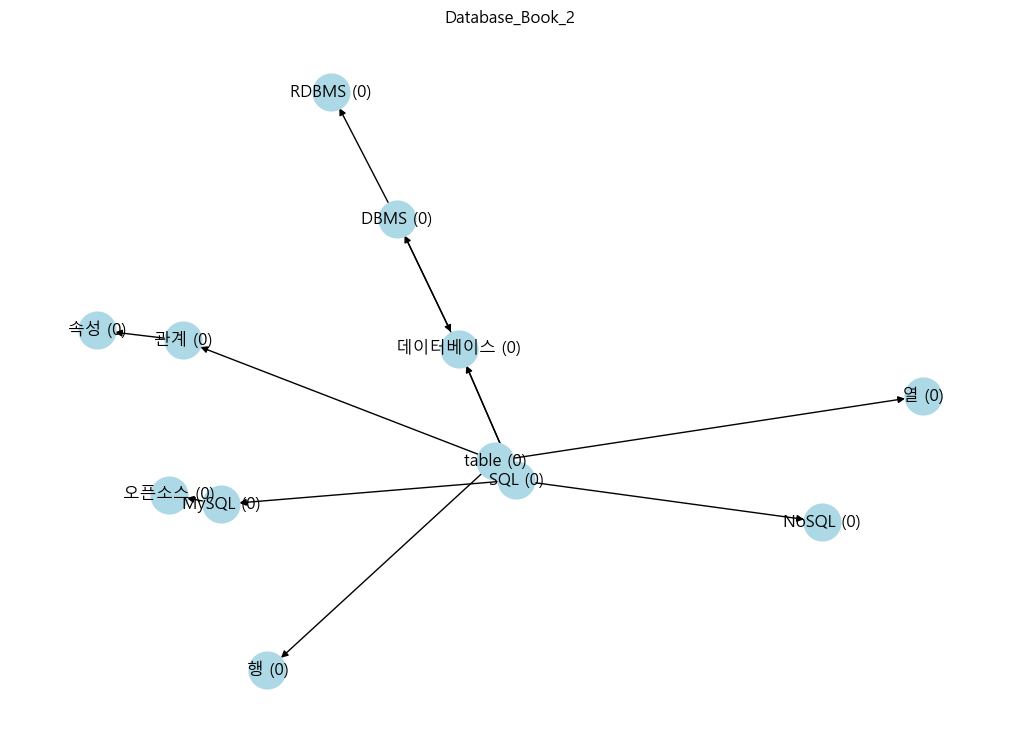

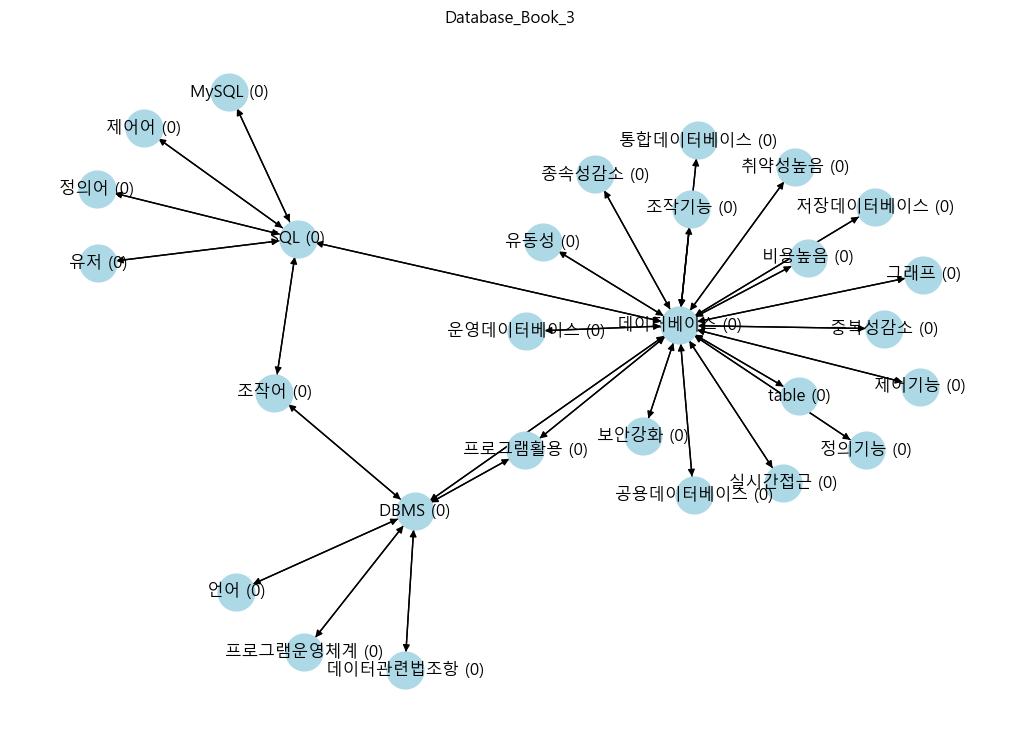

In [11]:
# Draw all graphs
# draw_graph(graphs_astronomy)
# draw_graph(graphs_sampling)
# draw_graph(graphs_database)

# Sample
draw_graph(graphs_astronomy, "Astronomy_Web_3")
draw_graph(graphs_sampling, "Sampling_GPT_3")
draw_graph(graphs_database, "Database_Book_3")